# Appendix

## Bruna's Spectral GCN


Let's first implement Bruna's spectral GCN.

In [1]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import scipy.sparse.linalg as slinalg

class BrunaGraphConv(nn.Module):
    """
    Bruna's Spectral Graph Convolution Layer

    This implementation follows the original formulation by Joan Bruna et al.,
    using the eigendecomposition of the graph Laplacian for spectral convolution.
    """

    def __init__(self, in_features, out_features, n_nodes):
        """
        Initialize the Bruna Graph Convolution layer

        Args:
            in_features (int): Number of input features
            out_features (int): Number of output features
        """
        super(BrunaGraphConv, self).__init__()

        self.in_features = in_features
        self.out_features = out_features

        # Learnable spectral filter parameters
        self.weight = nn.Parameter(
            torch.FloatTensor(in_features, out_features, n_nodes-1)
        )

        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize weights using Glorot initialization"""
        nn.init.xavier_uniform_(self.weight)


    @staticmethod
    def get_laplacian_eigenvectors(adj):
        """
        Compute eigendecomposition of the normalized graph Laplacian

        Args:
            adj: Adjacency matrix

        Returns:
            eigenvalues, eigenvectors of the normalized Laplacian
        """
        # Compute normalized Laplacian
        # Add self-loops
        adj = adj + sp.eye(adj.shape[0])

        # Compute degree matrix
        deg = np.array(adj.sum(axis=1))
        Dsqrt_inv = sp.diags(1.0 / np.sqrt(deg).flatten())

        # Compute normalized Laplacian: D^(-1/2) A D^(-1/2)
        laplacian = sp.eye(adj.shape[0]) - Dsqrt_inv @ adj @ Dsqrt_inv

        # Compute eigendecomposition
        # Using k=adj.shape[0]-1 to get all non-zero eigenvalues
        eigenvals, eigenvecs = slinalg.eigsh(laplacian.tocsc(), k=adj.shape[0]-1,which='SM', tol=1e-6)

        return torch.FloatTensor(eigenvals), torch.FloatTensor(eigenvecs)

    def forward(self, x, eigenvecs):
        """
        Forward pass implementing Bruna's spectral convolution

        Args:
            x: Input features [num_nodes, in_features]
            eigenvecs: Eigenvectors of the graph Laplacian [num_nodes, num_nodes-1]

        Returns:
            Output features [num_nodes, out_features]
        """
        # Transform to spectral domain
        x_spectral = torch.matmul(eigenvecs.t(), x)  # [num_nodes-1, in_features]

        # Initialize output tensor
        out = torch.zeros(x.size(0), self.out_features, device=x.device)

        # For each input-output feature pair
        for i in range(self.in_features):
            for j in range(self.out_features):
                # Element-wise multiplication in spectral domain
                # This is the actual spectral filtering operation
                filtered = x_spectral[:, i] * self.weight[i, j, :]  # [num_spectrum]

                # Transform back to spatial domain and accumulate
                out[:, j] += torch.matmul(eigenvecs, filtered)

        return out

Next, we will train the model on the karate club network to predict the given node labels indicating nodes' community memberships. We load the data by

In [2]:
import networkx as nx
import torch
import matplotlib.pyplot as plt

# Load karate club network
G = nx.karate_club_graph()
adj = nx.to_scipy_sparse_array(G)
features = torch.eye(G.number_of_nodes())
labels = torch.tensor([G.nodes[i]['club'] == 'Officer' for i in G.nodes()], dtype=torch.long)

We apply the convolution twice with ReLu activation in between. This can be implemented by preparing two independent `BrunaGraphConv` layers, applying them consecutively, and adding a ReLu activation in between.

In [3]:
# Define a simple GCN model
class SimpleGCN(nn.Module):
    def __init__(self, in_features, out_features, hidden_features, n_nodes):
        super(SimpleGCN, self).__init__()
        self.conv1 = BrunaGraphConv(in_features, hidden_features, n_nodes)
        self.relu = nn.ReLU()
        self.conv2 = BrunaGraphConv(hidden_features, out_features, n_nodes)

    def forward(self, x, eigenvecs):
        x = self.conv1(x, eigenvecs)
        x = self.relu(x)
        x = self.conv2(x, eigenvecs)
        return x

We then train the model by

In [4]:
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Get eigenvectors of the Laplacian
eigenvals, eigenvecs = BrunaGraphConv.get_laplacian_eigenvectors(adj)

# Initialize the model
hidden_features = 10
input_features = features.shape[1]
output_features = 2
n_nodes = G.number_of_nodes()
model = SimpleGCN(input_features, output_features, hidden_features, n_nodes)

# Train the model
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Split the data into training and testing sets
train_idx, test_idx = train_test_split(np.arange(G.number_of_nodes()), test_size=0.2, random_state=42)
train_features = features[train_idx]
train_labels = labels[train_idx]
test_features = features[test_idx]
test_labels = labels[test_idx]


n_train = 100
for epoch in range(n_train):
    model.train()
    optimizer.zero_grad()
    output = model(train_features, eigenvecs[train_idx, :])
    loss = criterion(output, train_labels)
    loss.backward()
    optimizer.step()

    # Evaluate the model
    if epoch == 0 or (epoch+1) % 25 == 0:
        model.eval()
        with torch.no_grad():
            output = model(test_features, eigenvecs[test_idx, :])
            _, predicted = torch.max(output, 1)
            accuracy = (predicted == test_labels).float().mean()
            print(f'Epoch {epoch+1}/{n_train}, Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

Epoch 1/100, Loss: 0.6933, Accuracy: 0.4286


Epoch 25/100, Loss: 0.1456, Accuracy: 0.4286


Epoch 50/100, Loss: 0.0056, Accuracy: 0.4286


Epoch 75/100, Loss: 0.0020, Accuracy: 0.4286


Epoch 100/100, Loss: 0.0013, Accuracy: 0.4286


Observe that the accuracy increases as the training progresses. We can use the model to predict the labels.
The model has a hidden layer, and let's visualize the data in the hidden space.

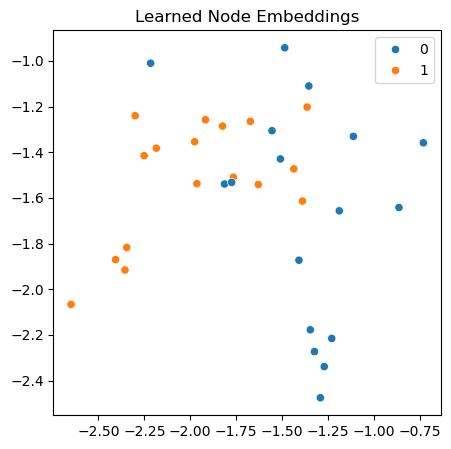

In [5]:
import seaborn as sns
from sklearn.manifold import TSNE

# Visualize the learned embeddings
embeddings = model.conv1(features, eigenvecs).detach().numpy()

xy = TSNE(n_components=2).fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x = xy[:, 0].reshape(-1), y = xy[:, 1].reshape(-1), hue=labels.numpy(), palette='tab10', ax = ax)
ax.set_title("Learned Node Embeddings")
plt.show()

## ChebNet

Let's implement the ChebNet layer.

In [6]:
import numpy as np
import torch
import torch.nn as nn
import scipy.sparse as sp
from typing import Optional


def sparse_mx_to_torch_sparse(sparse_mx):
    """Convert scipy sparse matrix to torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo()
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64)
    )
    values = torch.from_numpy(sparse_mx.data.astype(np.float32))
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse_coo_tensor(indices, values, shape)


class ChebConv(nn.Module):
    """
    Chebyshev Spectral Graph Convolutional Layer
    """

    def __init__(self, in_channels: int, out_channels: int, K: int, bias: bool = True):
        super(ChebConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.K = K

        # Trainable parameters
        self.weight = nn.Parameter(torch.Tensor(K, in_channels, out_channels))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter("bias", None)

        self.reset_parameters()

    def reset_parameters(self):
        """Initialize parameters."""
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def _normalize_laplacian(self, adj_matrix):
        """
        Compute normalized Laplacian L = I - D^(-1/2)AD^(-1/2)
        """
        # Convert to scipy if it's not already
        if not sp.isspmatrix(adj_matrix):
            adj_matrix = sp.csr_matrix(adj_matrix)

        adj_matrix = adj_matrix.astype(float)

        # Compute degree matrix D
        rowsum = np.array(adj_matrix.sum(1)).flatten()
        d_inv_sqrt = np.power(rowsum, -0.5)
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt)

        # Compute L = I - D^(-1/2)AD^(-1/2)
        n = adj_matrix.shape[0]
        L = sp.eye(n) - d_mat_inv_sqrt @ adj_matrix @ d_mat_inv_sqrt
        return L

    def _scale_laplacian(self, L):
        """
        Scale Laplacian eigenvalues to [-1, 1] interval
        L_scaled = 2L/lambda_max - I
        """
        try:
            # Compute largest eigenvalue
            eigenval, _ = sp.linalg.eigsh(L, k=1, which="LM", return_eigenvectors=False)
            lambda_max = eigenval[0]
        except:
            # Approximate lambda_max = 2 if eigenvalue computation fails
            lambda_max = 2.0

        n = L.shape[0]
        L_scaled = (2.0 / lambda_max) * L - sp.eye(n)
        return L_scaled

    def chebyshev_basis(self, L_sparse: torch.sparse.Tensor, X: torch.Tensor):
        """
        Compute Chebyshev polynomials basis up to order K.
        """
        # List to store Chebyshev polynomials
        cheb_polynomials = []

        # T_0(L) = I
        cheb_polynomials.append(X)

        if self.K > 1:
            # T_1(L) = L
            X_1 = torch.sparse.mm(L_sparse, X)
            cheb_polynomials.append(X_1)

        # Recurrence T_k(L) = 2L·T_{k-1}(L) - T_{k-2}(L)
        for k in range(2, self.K):
            X_k = (
                2 * torch.sparse.mm(L_sparse, cheb_polynomials[k - 1])
                - cheb_polynomials[k - 2]
            )
            cheb_polynomials.append(X_k)

        return torch.stack(cheb_polynomials, dim=0)  # [K, num_nodes, in_channels]

    def forward(self, X: torch.Tensor, adj_matrix: sp.spmatrix):
        """
        Forward pass.

        Args:
            X: Node features tensor of shape [num_nodes, in_channels]
            adj_matrix: Adjacency matrix in scipy sparse format

        Returns:
            Output tensor of shape [num_nodes, out_channels]
        """
        # Compute normalized and scaled Laplacian
        L_norm = self._normalize_laplacian(adj_matrix)
        L_scaled = self._scale_laplacian(L_norm)

        # Convert to torch sparse tensor
        L_scaled = sparse_mx_to_torch_sparse(L_scaled).to(X.device)

        # Compute Chebyshev polynomials basis
        Tx = self.chebyshev_basis(L_scaled, X)  # [K, num_nodes, in_channels]

        # Perform convolution using learned weights
        out = torch.einsum("kni,kio->no", Tx, self.weight)

        if self.bias is not None:
            out += self.bias

        return out

We stack the layers to form a simple GCN model.

In [7]:
class ChebNet(nn.Module):
    """
    ChebNet model for node classification
    """

    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        K: int,
        num_layers: int,
        dropout: float = 0.5,
    ):
        super(ChebNet, self).__init__()

        self.convs = nn.ModuleList()

        # First layer
        self.convs.append(ChebConv(in_channels, hidden_channels, K))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(ChebConv(hidden_channels, hidden_channels, K))

        # Output layer
        self.convs.append(ChebConv(hidden_channels, out_channels, K))

        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, X: torch.Tensor, adj_matrix: sp.spmatrix):
        """
        Forward pass through all layers
        """
        for i, conv in enumerate(self.convs[:-1]):
            X = conv(X, adj_matrix)
            X = self.activation(X)
            X = self.dropout(X)

        # Output layer
        X = self.convs[-1](X, adj_matrix)
        return X

Let's train the model on the karate club network.

In [8]:
import seaborn as sns
from sklearn.manifold import TSNE

import networkx as nx
import torch
import matplotlib.pyplot as plt

# Load karate club network
G = nx.karate_club_graph()
adj = nx.to_scipy_sparse_array(G)
features = torch.eye(G.number_of_nodes())
labels = torch.tensor(
    [G.nodes[i]["club"] == "Officer" for i in G.nodes()], dtype=torch.long
)

# Initialize the model
hidden_features = 10
input_features = features.shape[1]
output_features = 2
n_nodes = G.number_of_nodes()
K = 3
num_layers = 2
dropout = 0.5

model = ChebNet(
    input_features, hidden_features, output_features, K, num_layers, dropout
)

import torch.optim as optim
from sklearn.model_selection import train_test_split

# Train the model
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Split the data into training and testing sets
train_idx, test_idx = train_test_split(
    np.arange(G.number_of_nodes()), test_size=0.2, random_state=42
)
train_features = features[train_idx]
train_labels = labels[train_idx]
test_features = features[test_idx]
test_labels = labels[test_idx]


n_train = 100
for epoch in range(n_train):
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss = criterion(output[train_idx], train_labels)
    loss.backward()
    optimizer.step()

    # Evaluate the model
    if epoch == 0 or (epoch + 1) % 25 == 0:
        model.eval()
        with torch.no_grad():
            output = model(features, adj)
            _, predicted = torch.max(output[test_idx], 1)
            accuracy = (predicted == test_labels).float().mean()
            print(
                f"Epoch {epoch+1}/{n_train}, Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}"
            )

Epoch 1/100, Loss: 0.7020, Accuracy: 0.2857
Epoch 25/100, Loss: 0.1083, Accuracy: 0.8571
Epoch 50/100, Loss: 0.0111, Accuracy: 0.8571


Epoch 75/100, Loss: 0.0019, Accuracy: 0.8571
Epoch 100/100, Loss: 0.0047, Accuracy: 0.8571


Let's visualize the learned embeddings.

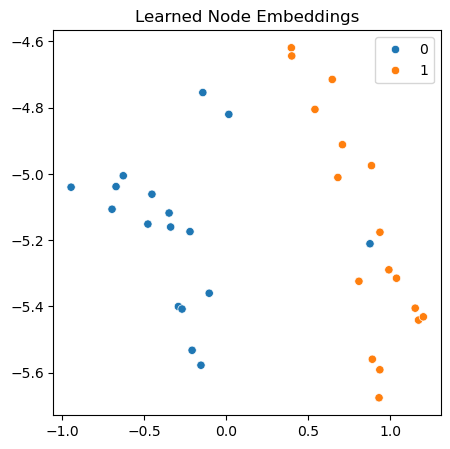

In [9]:
model.eval()
with torch.no_grad():
    # Get embeddings from the last hidden layer
    X_hidden = features
    for conv in model.convs[:-1]:
        X_hidden = conv(X_hidden, adj)
        X_hidden = model.activation(X_hidden)

# Reduce dimensionality for visualization
xy = TSNE(n_components=2).fit_transform(X_hidden.numpy())

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    x=xy[:, 0].reshape(-1),
    y=xy[:, 1].reshape(-1),
    hue=labels.numpy(),
    palette="tab10",
    ax=ax,
)
ax.set_title("Learned Node Embeddings")
plt.show()

---
jupytext:
  formats: md:myst
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3
  language: python
  name: python3
---


# From Image to Graph

## Analogy between image and graph data
We can think of a convolution of an image from the perspective of networks.
In the convolution of an image, a pixel is convolved with its *neighbors*. We can regard each pixel as a node, and each node is connected to its neighboring nodes (pixels) that are involved in the convolution.

![](https://av-eks-lekhak.s3.amazonaws.com/media/__sized__/article_images/conv_graph-thumbnail_webp-600x300.webp)

Building on this analogy, we can extend the idea of convolution to general graph data.
Each node has a pixel value(s) (e.g., feature vector), which is convolved with the values of its neighbors in the graph.
This is the key idea of graph convolutional networks.
But, there is a key difference: while the number of neighbors for an image is homogeneous, the number of neighbors for a node in a graph can be heterogeneous. Each pixel has the same number of neighbors (except for the boundary pixels), but nodes in a graph can have very different numbers of neighbors. This makes it non-trivial to define the "kernel" for graph convolution.

## Spectral filter on graphs
Just like we can define a convolution on images in the frequency domain, we can also define a ''frequency domain'' for graphs.

Consider a network of $N$ nodes, where each node has a feature variable ${\mathbf x}_i \in \mathbb{R}$. We are interested in:

$$
J = \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N A_{ij}(x_i - x_j)^2,
$$

where $A_{ij}$ is the adjacency matrix of the graph. The quantity $J$ represents *the total variation* of $x$ between connected nodes; a small $J$ means that connected nodes have similar $x$ (low variation; low frequency), while a large $J$ means that connected nodes have very different $x$ (high variation; high frequency).

We can rewrite $J$ as

$$
J = \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N A_{ij}(x_i - x_j)^2 = {\bf x}^\top {\bf L} {\bf x},
$$

where ${\bf L}$ is the Laplacian matrix of the graph given by

$$
L_{ij} = \begin{cases}
-1 & \text{if } i \text{ and } j \text{ are connected} \\
k_i & \text{if } i = j \\
0 & \text{otherwise}
\end{cases}.
$$

and ${\bf x} = [x_1,x_2,\ldots, x_N]^\top$ is a column vector of feature variables.


```{admonition} Detailed derivation
:tag: note
:class: dropdown

The above derivation shows that the total variation of $x$ between connected nodes is proportional to ${\bf x}^\top {\bf L} {\bf x}$.

$$
\begin{aligned}
J &= \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N A_{ij}(x_i - x_j)^2 \\
&= \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N \underbrace{A_{ij}\left( x_i^2 +x_j^2\right)}_{\text{symmetric}} - \sum_{i=1}^N\sum_{j=1}^N A_{ij}x_ix_j \\
&= \sum_{i=1}^Nx_i^2\underbrace{\sum_{j=1}^N A_{ij}}_{\text{degree of node } i, k_i} - \sum_{i=1}^N\sum_{j=1}^N A_{ij}x_ix_j \\
&= \sum_{i=1}^Nx_i^2 k_i - \sum_{i=1}^N\sum_{j=1}^N A_{ij}x_ix_j \\
&= \underbrace{[x_1,x_2,\ldots, x_N]}_{{\bf x}} \underbrace{\begin{bmatrix} k_1 & 0 & \cdots & 0 \\ 0 & k_2 & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \cdots & k_N \end{bmatrix}}_{{\bf D}} \underbrace{\begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_N \end{bmatrix}}_{{\bf x}} - 2\underbrace{\sum_{i=1}^N\sum_{j=1}^N A_{ij}}_{{\bf x}^\top {\mathbf A} {\bf x}} {\bf x} \\
&= {\bf x}^\top {\bf D} {\bf x} - {\bf x}^\top {\mathbf A} {\bf x} \\
&= {\bf x}^\top {\bf L} {\bf x},
\end{aligned}
$$
```

Let us showcase the analogy between the Fourier transform and the Laplacian matrix.
In the Fourier transform, a signal is decomposed into sinusoidal basis functions. Similarly, for a graph, we can decompose the variation $J$ into eigenvector bases.

$$
J = \sum_{i=1}^N \lambda_i  {\bf x}^\top {\mathbf u}_i {\mathbf u}_i^\top {\bf x} = \sum_{i=1}^N \lambda_i  ||{\bf x}^\top {\mathbf u}_i||^2.
$$

where ${\mathbf u}_i$ is the eigenvector corresponding to the eigenvalue $\lambda_i$.
- The term $({\bf x}^\top {\mathbf u}_i)$ is a dot-product between the feature vector ${\bf x}$ and the eigenvector ${\mathbf u}_i$, which measures how much ${\bf x}$ *coheres* with eigenvector ${\mathbf u}_i$, similar to how Fourier coefficients measure coherency with sinusoids.
- Each $||{\bf x}^\top {\mathbf u}_i||^2$ is the ''strength'' of ${\bf x}$ with respect to the eigenvector ${\mathbf u}_i$, and the total variation $J$ is a weighted sum of these strengths.

Some eigenvectors correspond to low-frequency components, while others correspond to high-frequency components. For example, the total variation $J$ for an eigenvector ${\mathbf u}_i$ is given by

$$
J = \frac{1}{2} \sum_{j}\sum_{\ell} A_{j\ell}(u_{ij} - u_{i\ell})^2 = {\mathbf u}_i^\top {\mathbf L} {\mathbf u}_i = \lambda_i.
$$

This equation provides key insight into the meaning of eigenvalues:

1. For an eigenvector ${\mathbf u}_i$, its eigenvalue $\lambda_i$ measures the total variation for ${\mathbf u}_i$.
2. Large eigenvalues mean large differences between neighbors (high frequency), while small eigenvalues mean small differences (low frequency).

Thus, if ${\bf x}$ aligns well with ${\mathbf u}_i$ with a large $\lambda_i$, then ${\bf x}$ has a strong high-frequency component; if ${\bf x}$ aligns well with ${\mathbf u}_i$ with a small $\lambda_i$, then ${\bf x}$ has strong low-frequency component.

### Spectral Filtering

Eigenvalues $\lambda_i$ can be thought of as a *filter* that controls which frequency components pass through. Instead of using the filter associated with the Laplacian matrix, we can design a filter $h(\lambda_i)$ to control which frequency components pass through. This leads to the idea of *spectral filtering*. Two common filters are:

1. **Low-pass Filter**:
   $$h_{\text{low}}(\lambda) = \frac{1}{1 + \alpha\lambda}$$
   - Preserves low frequencies (small λ)
   - Suppresses high frequencies (large λ)
   - Results in smoother signals

2. **High-pass Filter**:
   $$h_{\text{high}}(\lambda) = \frac{\alpha\lambda}{1 + \alpha\lambda}$$
   - Preserves high frequencies
   - Suppresses low frequencies
   - Emphasizes differences between neighbors

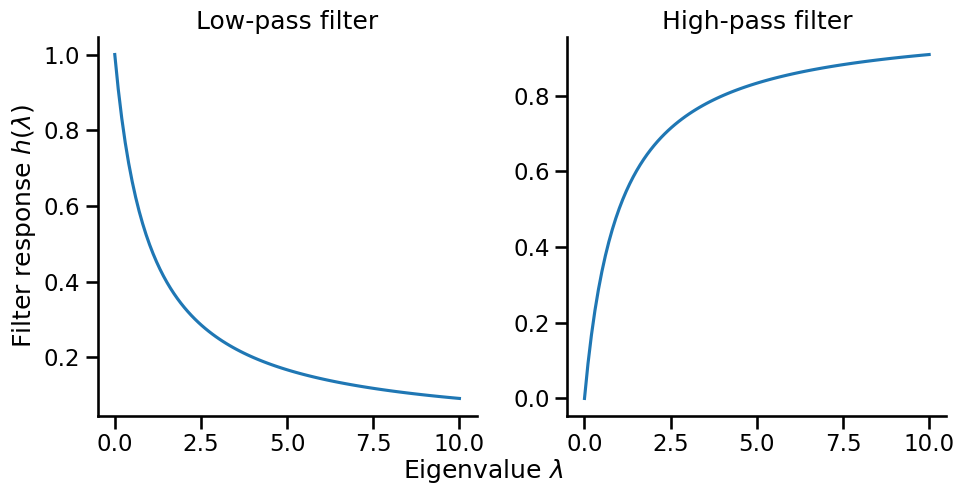

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

alpha = 1
lambdas = np.linspace(0, 10, 100)
h_low = 1 / (1 + alpha * lambdas)
h_high = (alpha * lambdas) / (1 + alpha * lambdas)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=lambdas, y=h_low, label="Low-pass filter", ax=axes[0])
axes[0].legend(frameon=False).remove()
sns.lineplot(x=lambdas, y=h_high, label="High-pass filter", ax=axes[1])
axes[1].legend(frameon=False).remove()
axes[0].set_title("Low-pass filter")
axes[1].set_title("High-pass filter")
fig.text(0.5, 0.01, "Eigenvalue $\lambda$", ha="center")
axes[0].set_ylabel("Filter response $h(\lambda)$")
sns.despine()
plt.tight_layout()

### Example

Let us showcase the idea of spectral filtering with a simple example with the karate club network.

In [11]:
import igraph as ig
import numpy as np
from scipy import sparse
import matplotlib as mpl

G = ig.Graph.Famous("Zachary")
A = G.get_adjacency_sparse()

We will first compute the laplacian matrix and its eigendecomposition.

In [12]:
# Compute Laplacian matrix
deg = np.array(A.sum(axis=1)).reshape(-1)
D = sparse.diags(deg)
L = D - A

# Compute eigendecomposition
evals, evecs = np.linalg.eigh(L.toarray())

# Sort eigenvalues and eigenvectors
order = np.argsort(evals)
evals = evals[order]
evecs = evecs[:, order]

Now, let's create a low-pass and high-pass filter.

In [13]:
alpha = 2
L_low = evecs @ np.diag(1 / (1 + alpha * evals)) @ evecs.T
L_high = evecs @ np.diag(alpha * evals / (1 + alpha * evals)) @ evecs.T

print("Size of low-pass filter:", L_low.shape)
print("Size of high-pass filter:", L_high.shape)

Size of low-pass filter: (34, 34)
Size of high-pass filter: (34, 34)


Notice that the high-pass filter and low-pass filter are matrices of the same size as the adjacency matrix $A$, which defines a 'convolution' on the graph as follows:

$$
{\bf x}' = {\bf L}_{\text{low}} {\bf x} \quad \text{or} \quad {\bf x}' = {\bf L}_{\text{high}} {\bf x}.
$$

where ${\bf L}_{\text{low}}$ and ${\bf L}_{\text{high}}$ are the low-pass and high-pass filters, respectively, and ${\bf x}'$ is the convolved feature vector.

Now, let's see how these filters work. Our first example is a random feature vector.

In [14]:
# Random feature vector
x = np.random.randn(A.shape[0], 1)

# Convolve with low-pass filter
x_low = L_low @ x

# Convolve with high-pass filter
x_high = L_high @ x

Let us visualize the results.

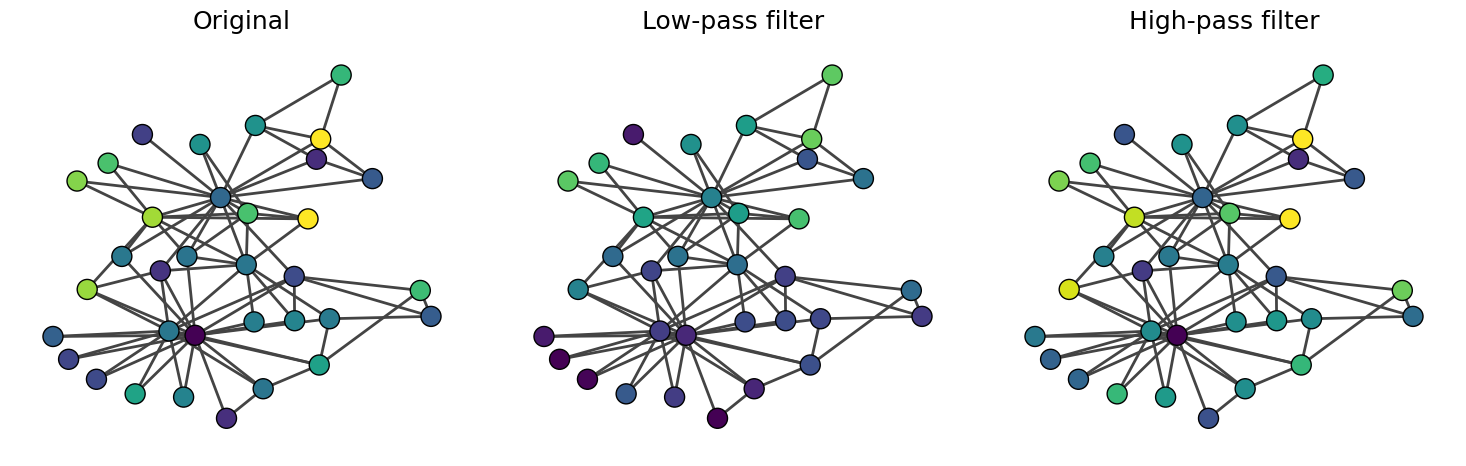

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
palette = sns.color_palette("viridis", as_cmap=True)
norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)

# Original
values = x.reshape(-1)
values /= np.linalg.norm(values)
ig.plot(G, vertex_color=[palette(norm(x)) for x in values], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[0])
axes[0].set_title("Original")

# Low-pass filter applied
values = L_low @ x
values /= np.linalg.norm(values)
values = values.reshape(-1)
ig.plot(G, vertex_color=[palette(norm(x)) for x in values], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[1])
axes[1].set_title("Low-pass filter")

# High-pass filter applied
values = L_high @ x
values /= np.linalg.norm(values)
values = values.reshape(-1)
ig.plot(G, vertex_color=[palette(norm(x)) for x in values], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[2])
axes[2].set_title("High-pass filter")
fig.tight_layout()

We observe that the low-pass filter results in smoother ${\bf x}$ between connected nodes (i.e., neighboring nodes have similar ${\bf x}$).
The original ${\bf x}$ and ${\bf x}'_{\text{low}}$ are very similar because random variables are high-frequency components. In contrast, when we apply the high-pass filter, ${\bf x}'_{\text{high}}$ is similar to ${\bf x}$ because the high-frequency components are not filtered.

Let's now use an eigenvector as our feature vector ${\bf x}$.

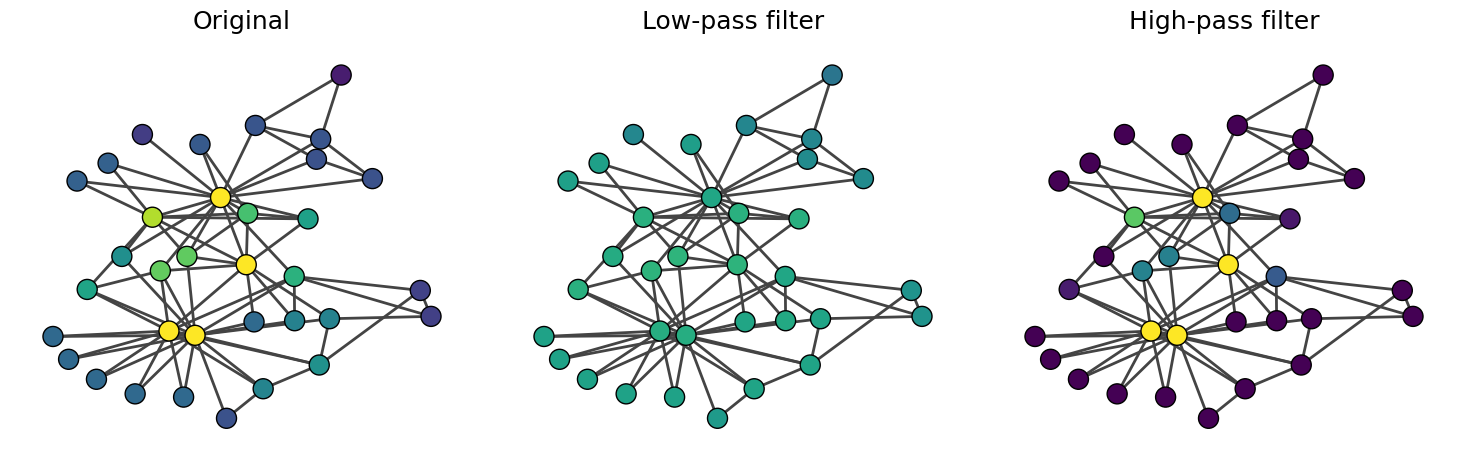

In [16]:
eigen_centrality = np.array(G.eigenvector_centrality()).reshape(-1, 1)
low_pass_eigen = L_low @ eigen_centrality
high_pass_eigen = L_high @ eigen_centrality

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
palette = sns.color_palette("viridis", as_cmap=True)

norm = mpl.colors.Normalize(vmin=-0, vmax=0.3)
values = eigen_centrality.reshape(-1)# high_pass_random.reshape(-1)
values /= np.linalg.norm(values)
values = values.reshape(-1)
ig.plot(G, vertex_color=[palette(norm(x)) for x in values], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[0])
axes[0].set_title("Original")

values = low_pass_eigen.reshape(-1)
values /= np.linalg.norm(values)
values = values.reshape(-1)
ig.plot(G, vertex_color=[palette(norm(x)) for x in values], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[1])
axes[1].set_title("Low-pass filter")

values = high_pass_eigen.reshape(-1)
values /= np.linalg.norm(values)
ig.plot(G, vertex_color=[palette(norm(x)) for x in values], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[2])
axes[2].set_title("High-pass filter")
fig.tight_layout()

The high-pass filter increases the contrast of the eigenvector centrality, emphasizing the differences between nodes. On the other hand, the low-pass filter smooths out the eigenvector centrality.
---
jupytext:
  formats: md:myst
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3
  language: python
  name: python3
---


# Graph Convolutional Networks
We have seen that spectral filters give us a principled way to think about "convolution" on irregular graph structures, and controlling the frequency components brings out different aspects of the data. We now go one step further: instead of designing filters by hand, we can learn them from data for specific tasks.


## Spectral Graph Convolutional Networks

A simplest form of learnable spectral filter is given by

$$
{\bf L}_{\text{learn}} = \sum_{k=1}^K \theta_k {\mathbf u}_k {\mathbf u}_k^\top,
$$

where ${\mathbf u}_k$ are the eigenvectors and $\theta_k$ are the learnable parameters. The variable $K$ is the number of eigenvectors used (i.e., the rank of the filter). The weight $\theta_k$ is learned to maximize the performance of the task at hand.

Building on this idea, {footcite}`bruna2014spectral` added a nonlinearity to the filter and proposed a spectral convolutional neural network (GCN) by

$$
{\bf x}^{(\ell+1)} = h\left( L_{\text{learn}} {\bf x}^{(\ell)}\right),
$$

where $h$ is an activation function, and ${\bf x}^{(\ell)}$ is the feature vector of the $\ell$-th convolution. They further extend this idea to convolve on multidimensional feature vectors, ${\bf X} \in \mathbb{R}^{N \times f_{\text{in}}}$ to produce new feature vectors of different dimensionality, ${\bf X}' \in \mathbb{R}^{N \times f_{\text{out}}}$.

$$
\begin{aligned}
{\bf X}^{(\ell+1)}_i &= h\left( \sum_j L_{\text{learn}}^{(i,j)} {\bf X}^{(\ell)}_j\right),\quad \text{where} \quad L^{(i,j)}_{\text{learn}} = \sum_{k=1}^K \theta_{k, (i,j)} {\mathbf u}_k {\mathbf u}_k^\top,
\end{aligned}
$$

Notice that the learnable filter $L_{\text{learn}}^{(i,j)}$ is defined for each pair of input $i$ and output $j$ dimensions.


```{note}
Many GCNs simple when it comes to implementation despite the complicated formula. And this is one of my ways to learn GNNs. Check out the [Appendix for the Python implementation](appendix.md).

```

## From Spectral to Spatial

Spectral GCNs are mathematically elegant but have two main limitations:
1. **Computational Limitation**: Computing the spectra of the Laplacian is expensive ${\cal O}(N^3)$ and prohibitive for large graphs
2. **Spatial Locality**: The learned filters are not spatially localized. A node can be influenced by all other nodes in the graph.

These two limitations motivate the development of spatial GCNs.

### ChebNet

ChebNet {footcite}`defferrard2016convolutional` is one of the earliest spatial GCNs that bridges the gap between spectral and spatial domains.
The key idea is to leverage Chebyshev polynomials to approximate ${\bf L}_{\text{learn}}$ by

$$
{\bf L}_{\text{learn}} \approx \sum_{k=0}^{K-1} \theta_k T_k(\tilde{{\bf L}}), \quad \text{where} \quad \tilde{{\bf L}} = \frac{2}{\lambda_{\text{max}}}{\bf L} - {\bf I},
$$

where $\tilde{{\bf L}}$ is the scaled and normalized Laplacian matrix in order to have eigenvalues in the range of $[-1,1]$. The Chebyshev polynomials $T_k(\tilde{{\bf L}})$ transforms the eigenvalues $\tilde{{\bf L}}$ to the following recursively:

$$
\begin{aligned}
T_0(\tilde{{\bf L}}) &= {\bf I} \\
T_1(\tilde{{\bf L}}) &= \tilde{{\bf L}} \\
T_k(\tilde{{\bf L}}) &= 2\tilde{{\bf L}} T_{k-1}(\tilde{{\bf L}}) - T_{k-2}(\tilde{{\bf L}})
\end{aligned}
$$

We then replace ${\bf L}_{\text{learn}}$ in the original spectral GCN with the Chebyshev polynomial approximation:

$$
{\bf x}^{(\ell+1)} = h\left( \sum_{k=0}^{K-1} \theta_k T_k(\tilde{{\bf L}}){\bf x}^{(\ell)}\right),
$$

where:
- $T_k(\tilde{{\bf L}})$ applies the k-th Chebyshev polynomial to the scaled Laplacian matrix
- $\theta_k$ are the learnable parameters
- K is the order of the polynomial (typically small, e.g., K=3)

### Graph Convolutional Networks by Kipf and Welling

While ChebNet offers a principled way to approximate spectral convolutions, Kipf and Welling (2017) {footcite}`kipf2017semi` proposed an even simpler and highly effective variant called **Graph Convolutional Networks (GCN)**.


#### First-order Approximation

The key departure is to use the first-order approximation of the Chebyshev polynomials.

$$
g_{\theta'} * x \approx \theta'_0x + \theta'_1(L - I_N)x = \theta'_0x - \theta'_1D^{-\frac{1}{2}}AD^{-\frac{1}{2}}x
$$

This is crude approximation but it leads to a much simpler form, leaving only two learnable parameters, instead of $K$ parameters in the original ChebNet.

Additionally, they further simplify the formula by using the same $\theta$ for both remaining parameters (i.e., $\theta_0 = \theta$ and $\theta_1 = -\theta$). The result is the following convolutional filter:

$$
g_{\theta} * x \approx \theta(I_N + D^{-\frac{1}{2}}AD^{-\frac{1}{2}})x
$$

While this is a very simple filter, one can stack multiple layers of convolutions to perform high-order graph convolutions.

#### Deep GCNs can suffer from over-smoothing

GCN models can be deep, and when they are too deep, they start suffering from an ill-posed problem called *gradient vanishing/exploding*, where the gradients of the loss function becomes too small or too large to update the model parameters. It is a common problem in deep learning.

To facilitate the training of deep GCNs, the authors introduce a very simple trick called *renormalization*. The idea is to add self-connections to the graph:

$$
\tilde{A} = A + I_N, \quad \text{and} \quad \tilde{D}_{ii} = \sum_j \tilde{A}_{ij}
$$

And use $\tilde{A}$ and $\tilde{D}$ to form the convolutional filter.

Altogether, this leads to the following layer-wise propagation rule:

$$X^{(\ell+1)} = \sigma(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}X^{(\ell)}W^{(\ell)})$$

where:
- $X^{(\ell)}$ is the matrix of node features at layer $\ell$
- $W^{(\ell)}$ is the layer's trainable weight matrix
- $\sigma$ is a nonlinear activation function (e.g., ReLU)

These simplifications offer several advantages:
- **Efficiency**: Linear complexity in number of edges
- **Localization**: Each layer only aggregates information from immediate neighbors
- **Depth**: Fewer parameters allow building deeper models
- **Performance**: Despite (or perhaps due to) its simplicity, it often outperforms more complex models

```{admonition} Exercise
:class: note

Let's implement a simple GCN model for node classification.
[Coding Exercise](../../../notebooks/exercise-m09-graph-neural-net.ipynb)
```


```{footbibliography}
```---
jupytext:
  formats: md:myst
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3
  language: python
  name: python3
---

# Preliminaries: Image Processing

Graph Neural Networks are a type of neural network for graph data. node2vec and deepwalk stem from the idea of language modeling.
In this module, we will focus on another branch of graph neural networks that stem from image processing.

## Edge Detection Problem in Image Processing

Edge detection is a classical problem in image processing. The goal is to identify the boundaries of objects in an image.

![](https://media.geeksforgeeks.org/wp-content/uploads/20240616211411/Screenshot-(85).webp)

To approach the problem, let us first remind that an image is a matrix of pixels. Each pixel has RGB values, each of which represents the intensity of red, green, and blue color. To simplify the problem, we focus on grayscale images, in which each pixel has only one value representing the brightness. In this case, an image can be represented as a 2D matrix, where each element in the matrix represents the brightness of a pixel.

![](https://ai.stanford.edu/~syyeung/cvweb/Pictures1/imagematrix.png)

### An example

Human eyes are very sensitive to brightness changes. An edge in an image appears when there is a *significant brightness change between adjacent pixels*. To be more concrete, let's consider a small example consisting of 6x6 pixels, with a vertical line from the top to the bottom, where the brightness is higher than the neighboring pixels. This is an edge we want to detect.

$$
X = \begin{bmatrix}
10 & 10 & 80 & 10 & 10 & 10 \\
10 & 10 & 80 & 10 & 10 & 10 \\
10 & 10 & 80 & 10 & 10 & 10 \\
10 & 10 & 80 & 10 & 10 & 10 \\
10 & 10 & 80 & 10 & 10 & 10 \\
10 & 10 & 80 & 10 & 10 & 10
\end{bmatrix}
$$

Let's zoom on the pixel at (3, 3) and its surrounding pixels.

$$
Z = \begin{bmatrix}
10 & 80 & 10 \\
\textcolor{blue}{10} & \textcolor{red}{80} & \textcolor{purple}{10} \\
10 & 80 & 10
\end{bmatrix}
$$

where the central pixel is highlighted in red. Since we are interested in the edge which is a sudden change in brightness along the horizontal direction, we take a derivative at the central pixel by

$$
\nabla Z_{22} = \textcolor{blue}{Z_{2,1}} - \textcolor{purple}{Z_{2,3}}
$$

Following the same process, we can compute the derivative at all pixels, which gives us the (horizontal) derivative of the image.

$$
\begin{bmatrix}
- & -70 & 0 & 70 & 0 & - \\
- & -70 & 0 & 70 & 0 & - \\
- & -70 & 0 & 70 & 0 & - \\
- & -70 & 0 & 70 & 0 & - \\
- & -70 & 0 & 70 & 0 & -
\end{bmatrix}
$$

The symbol `-` indicates that the derivative is not defined because one of the neighboring pixels is out of the image boundary.
We observe that the derivative is high at the edge and low elsewhere. This is a simple but effective way to detect edges in an image.

We can consider a derivative operator along the vertical direction that computes the difference between the vertical neighboring pixels.

$$
\nabla Z_{22} = Z_{1,2} - Z_{3,2}
$$

And, when applied to the entire image, the result is

$$
\begin{bmatrix}
- & - & - & - & -  & - \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
- & - & - & - & - & -
\end{bmatrix}
$$

The all entries are zero, meaning that there is no edge in the vertical direction.

We can combine the horizontal and vertical derivatives to get the gradient of the image. For example,

$$
\nabla Z_{22} = Z_{12} - Z_{32} + Z_{21} - Z_{23}
$$

When applied to the entire image, the result is the same as the horizontal derivative.

### Convolution

We observe that there is a repeated pattern in the derivative computation: we are taking addition and subtraction of neighbiring pixels. This motivates us to generalize the operation to a more general form.

$$
\nabla Z_{22} = \sum_{i=-1}^1 \sum_{j=-1}^1 K_{h-(i+1),w-(j+1)} Z_{2+i, 2+j}
$$

where $K$ is a $3 \times 3$ matrix, and $w=h=3$ represent the width and height of the kernel.

$$
K = \begin{bmatrix}
K_{11} & K_{12} & K_{13} \\
K_{21} & K_{22} & K_{23} \\
K_{31} & K_{32} & K_{33}
\end{bmatrix}
$$

The matrix $K$ is called a **kernel**, and applying it to the image is called **convolution**.

```{note}
The index of the kernel is conventionally reversed. Namely, we reorder the entries of the kernel such that

$$
\begin{bmatrix}
K_{33} & K_{32} & K_{31} \\
K_{23} & K_{22} & K_{21} \\
K_{13} & K_{12} & K_{11}
\end{bmatrix}
$$

Then, take the element-wise product with $Z$

$$
\begin{bmatrix}
Z_{11} K_{33} & Z_{12} K_{32} & Z_{13} K_{31} \\
Z_{21} K_{23} & Z_{22} K_{22} & Z_{23} K_{21} \\
Z_{31} K_{13} & Z_{32} K_{12} & Z_{33} K_{11}
\end{bmatrix}
$$

and sum up all the elements to get the new pixel value $\nabla Z_{22}$.
Why do we reverse the kernel? This is to match with the mathematical definition of convolution, which will be introduced later.
```

```{tip}
In the previous example, we used a $3 \times 3$ kernels called the Prewitt operator, which in terms of $K$ is

$$
K_h = \begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1
\end{bmatrix}
\quad \text{or} \quad
K_v = \begin{bmatrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{bmatrix}
$$

where $K_h$ is the horizontal Prewitt operator and $K_v$ is the vertical Prewitt operator.
```

A kernel represents a local pattern we want to detect. The new pixel value after the convolution is maximized when the pattern is most similar to the kernel in terms of the inner product. This can be confirmed by:

$$
\nabla Z_{22} = \sum_{i=-1}^1 \sum_{j=-1}^1 K_{h-(i+1),w-(j+1)} Z_{2+i, 2+j} = \langle \hat K, Z \rangle
$$

where $\langle \cdot, \cdot \rangle$ is the inner product, and $\hat K$ is the order-reversed kernel.

```{note}
Check out this awesome interactive demo to see how different kernels work: [Demo](https://setosa.io/ev/image-kernels/)
```

## Fourier Transform

![](https://miro.medium.com/v2/resize:fit:1400/1*D6iRfzDkz-sEzyjYoVZ73w.gif)

Convolution computes the new pixel values by sliding a kernel over an image. How is the resulting image related to the original image?



To answer this question, let us consider a row of an image and convolve it with a kernel $K$.

$$
\begin{aligned}
X &= \begin{bmatrix}
X_1 & X_2 & X_3 & X_4 & X_5 & X_6
\end{bmatrix} \\
K &= \begin{bmatrix}
K_1 & K_2 & K_3
\end{bmatrix}
\end{aligned}
$$

The convolution of $X$ and $K$ is

$$
X * K = \begin{bmatrix}
X_1 K_3 + X_2 K_2 + X_3 K_1 & X_2 K_3 + X_3 K_2 + X_4 K_1 & X_3 K_3 + X_4 K_2 + X_5 K_1 & X_4 K_3 + X_5 K_2 + X_6 K_1
\end{bmatrix}
$$

...which is complicated, right? 😅 So let's make it simple by using a useful theorem called **the convolution theorem**.

The convolution theorem gives us a simpler way to think about convolution. Instead of doing the complex sliding window operation in the original domain (like pixel values), we can:

1. Transform both signals to the frequency domain using Fourier transform
2. Multiply them together (much simpler!)
3. Transform back to get the same result

Mathematically, the above steps can be written as:

1. $\mathcal{F}(X), \mathcal{F}(K)$ - Transform both signals to frequency domain (Fourier transform)
2. $\mathcal{F}(X) \cdot \mathcal{F}(K)$ - Multiply the transformed signals
3. $\mathcal{F}^{-1}(\mathcal{F}(X) \cdot \mathcal{F}(K))$ - Transform back to get $X * K$

where $\mathcal{F}^{-1}$ is the inverse Fourier transform that brings us back to the original domain. This is much easier than computing the convolution directly!

For a discrete signal $x[n]$ with $N$ points, the Fourier transform $\mathcal{F}$ is defined as:

$$
\mathcal{F}(x)[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-2\pi i \frac{nk}{N}}
$$

where $i$ is the imaginary unit. Or equivalently,

$$
\mathcal{F}(x)[k] = \sum_{n=0}^{N-1} x[n] \cdot \left[ \cos\left(2\pi \frac{nk}{N}\right) - i \sin\left(2\pi \frac{nk}{N}\right) \right]
$$

using Euler's formula $e^{ix} = \cos(x) + i\sin(x)$.

```{note}
Complex number can be thought of as a way to represent a 2D vector using a single value (which is a computer science perspective; mathematically, it is a bit more subtle). For example, $e^{i\pi/2} = \cos(\pi/2) + i\sin(\pi/2)$ represents the 2D vector $(\cos(\pi/2), \sin(\pi/2))$. In the context of Fourier transform, we interpret $e^{-2\pi i \frac{nk}{N}}$ as two *base waves*, i.e., sine and cosine, with phase $\frac{2\pi k}{N}$.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Euler%27s_formula.svg/360px-Euler%27s_formula.svg.png)
```

In simple terms, $\mathcal{F}$ takes a signal (like our row of pixel values) and breaks it down into sine and cosine waves of different frequencies. Each frequency component $k$ tells us "how much" of that frequency exists in our original signal.
Don't worry too much about the complex math. The key idea is that $\mathcal{F}$ represents a signal as a sum of multiple waves with different frequencies, so we can understand the signal in terms of its frequencies rather than its original values.


![](https://devincody.github.io/Blog/post/an_intuitive_interpretation_of_the_fourier_transform/img/FFT-Time-Frequency-View_hu24c1c8fe894ecd0dad24174b2bed08c9_99850_800x0_resize_lanczos_2.png)


```{note}
3Blue1Brown makes a beautiful video explaining Fourier transform: [Video](https://www.youtube.com/watch?v=spUNpyF58BY). Here is a great interactive demo on Fourier transform by Jez Swanson: [Demo](https://www.jezzamon.com/fourier/).
```

### An example for the Fourier transform

Now, let's perform the convolution using the Fourier transform using an example.

In [17]:
import numpy as np
X = np.array([10, 10, 80, 10, 10, 10])
K = np.array([-1, 0, 1])

Let us first perform the convolution directly.

In [18]:
# Pad X with zeros on both sides to handle boundary
n_conv = len(X) - len(K) + 1  # Now we get full length output
XKconv = np.zeros(n_conv)

for i in range(n_conv):
    XKconv[i] = np.sum(X[i:(i+len(K))] * K[::-1]) # Reverse the kernel and take element-wise product and sum up
XKconv

array([-70.,   0.,  70.,   0.])

Let us now perform the convolution using the Fourier transform. We compute the Fourier transform of $X$ and $K$.

In [19]:
# Step 1: Transform X and K to frequency domain
FX = np.fft.fft(X)
# Pad K with zeros to match the length of X before FFT
K_padded = np.pad(K, (0, len(X) - len(K)), 'constant') # [-1  0  1  0  0  0]
FK = np.fft.fft(K_padded)
print("FX:", FX)

FX: [130.+0.00000000e+00j -35.-6.06217783e+01j -35.+6.06217783e+01j
  70.+7.10542736e-15j -35.-6.06217783e+01j -35.+6.06217783e+01j]


- We add zeros to $K$ to make it the same length as $X$ before applying the Fourier transform. This is necessary because the convolution theorem requires the signals to have the same length.
- `FX` is the Fourier transform of $X$, which is a complex number. Each entry $FX[k]$ represents the weight of the cosine wave in its real part and the weight of the sine wave in its imaginary part, with phase $2\pi k / N$. Similarly for `FK`.

Next, we multiply the transformed signals.

In [20]:
FXKconv = FX * FK

This is the convolution in the frequency domain. Finally, we transform back to get the convolution.

In [21]:
XKconv_ft = np.real(np.fft.ifft(FXKconv))
XKconv_ft

array([ 2.84957243e-15,  3.05036092e-15, -7.00000000e+01,  1.88737914e-15,
        7.00000000e+01, -1.05195948e-15])

- We take the real part. The imaginary part is due to numerical artifacts that do not matter in practice.
- The Fourier transform convolution produces a longer output than direct convolution because it includes partial overlaps between K and X at the boundaries. Since we only want the full overlaps, we need to truncate the first two elements of `XKconv_ft` (as K has length 3) to match the length of the direct convolution result.
- For example, let's look at what happens at the beginning of the convolution:
  - At position -2: Only the last element of K overlaps with X: `[0, 0, 10] * [-1, 0, 1] = 10`
  - At position -1: Two elements of K overlap with X: `[0, 10, 10] * [-1, 0, 1] = 10`
  - At position 0: Full overlap begins: `[10, 10, 80] * [-1, 0, 1] = 70`

  The Fourier transform method gives us all these positions (-2, -1, 0, ...), but we only want the full overlaps starting from position 0, which is why we truncate the first two elements.

In [22]:
XKconv_ft = XKconv_ft[2:]
XKconv_ft

array([-7.00000000e+01,  1.88737914e-15,  7.00000000e+01, -1.05195948e-15])

This gives us the same result as the direct convolution up to numerical errors.

## Fourier Transform of Images

Let's extend the above example to an image which is a 2D matrix.
The idea is the same: we take the Fourier transform of each row and column of the image, and then multiply them together to get the convolution in the frequency domain.
More specifically, for an image $X$ with size $H \times W$, the Fourier transform of $X$ is

$$
\begin{aligned}
\mathcal{F}(X)[h, w] &= \sum_{k=0}^{H-1} \sum_{\ell=0}^{W-1} X[k, \ell] \cdot e^{-2\pi i \frac{hk}{H}} \cdot e^{-2\pi i \frac{w\ell}{W}} \\
&= \sum_{k=0}^{H-1} \sum_{\ell=0}^{W-1} X[k, \ell] e^{-2\pi i \left(\frac{hk}{H} + \frac{w\ell}{W}\right)}
\end{aligned}
$$

Comparing with the 1D case, we see that the 2D Fourier transform is *functionally* the same as the 1D Fourier transform, except that we now have two indices $h$ and $w$ to represent the frequency in both dimensions.
The basis waves are 2D waves as shown below.

**Cosine waves**

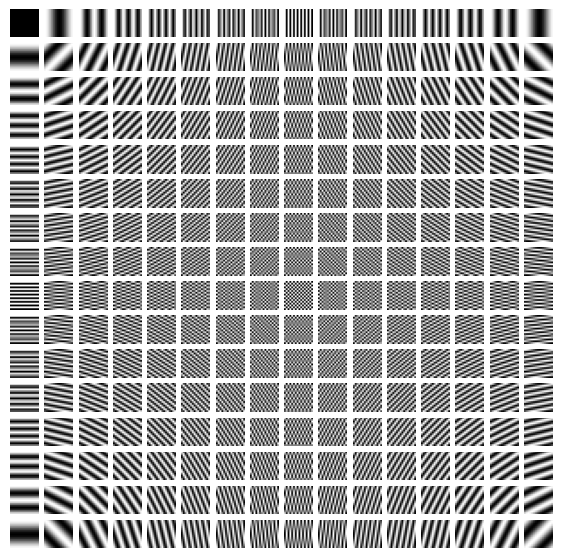

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def basis_function(img_size=256, u=0, v=0):
  '''
  img_size : square size of image f(x,y)
  u,v : spatial space indice
  '''
  N = img_size
  x = np.linspace(0, N-1, N)
  y = np.linspace(0, N-1, N)
  x_, y_ = np.meshgrid(x, y)
  bf = np.exp(-1j*2*np.pi*(u*x_/N+v*y_/N))
  if u == 0 and v == 0:
    bf = np.round(bf)
  real = np.real(bf) # The cosine part
  imag = np.imag(bf) # The sine part
  return real, imag

size = 16
bf_arr_real = np.zeros((size*size,size,size))
bf_arr_imag = np.zeros((size*size,size,size))
ind = 0
for col in range(size):
  for row in range(size):
    re,imag = basis_function(img_size=size, u=row, v=col)
    bf_arr_real[ind] = re
    bf_arr_imag[ind] = imag
    ind += 1

# real part
_, axs = plt.subplots(size, size, figsize=(7, 7))
axs = axs.flatten()
for img, ax in zip(bf_arr_real, axs):
  ax.set_axis_off()
  ax.imshow(img,cmap='gray')

**Sine waves**

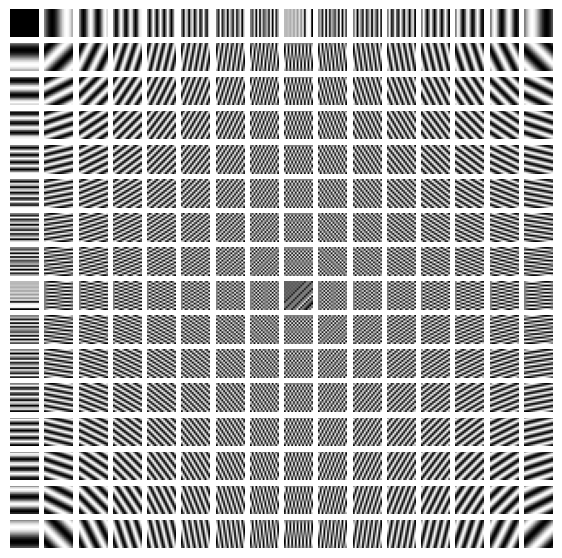

In [24]:
# imaginary part
_, axs = plt.subplots(size, size, figsize=(7, 7))
axs = axs.flatten()
for img, ax in zip(bf_arr_imag, axs):
  ax.set_axis_off()
  ax.imshow(img,cmap='gray')

The Fourier transform of an image is a decomposition of an image into the sum of these basis waves.

### An example of Fourier transform

Let us apply the Fourier transform to an image.

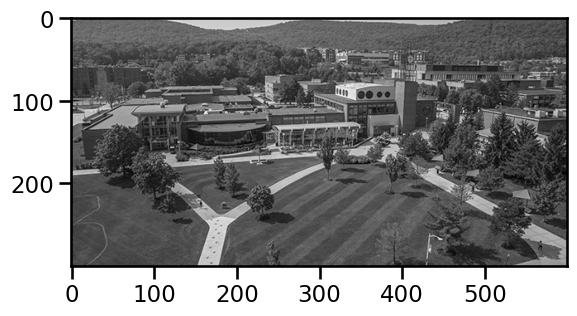

In [25]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

# Read image from URL
def read_jpeg_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # Convert to RGB mode if needed (in case it's RGBA)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def image_to_numpy(img):
    return np.array(img)

def to_gray_scale(img_np):
    return np.mean(img_np, axis=2)

# URL of the image
url = "https://www.binghamton.edu/news/images/uploads/features/20180815_peacequad02_jwc.jpg"

img = read_jpeg_from_url(url)
img_np = image_to_numpy(img)
img_gray = to_gray_scale(img_np)

plt.imshow(img_gray, cmap='gray')

Take the Fourier transform of the image.

In [26]:
ft_img_gray = np.fft.fft2(img_gray)

This decomposes the image into a sum of basis waves. Let's see the weights of the basis waves.

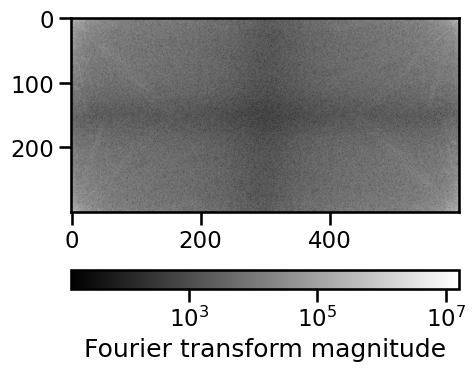

In [27]:
import matplotlib

weight = np.abs(ft_img_gray)

# real part
fig1, ax1 = plt.subplots(figsize=(5, 5))

ax1.imshow(weight, cmap='gray', norm=matplotlib.colors.LogNorm(), aspect='equal')
cbar = fig1.colorbar(ax1.images[0], ax=ax1, orientation='horizontal')
cbar.set_label('Fourier transform magnitude')

The corresponding basis waves look like this:

Text(0.5, 0.98, 'Imaginary Part of Basis Functions')

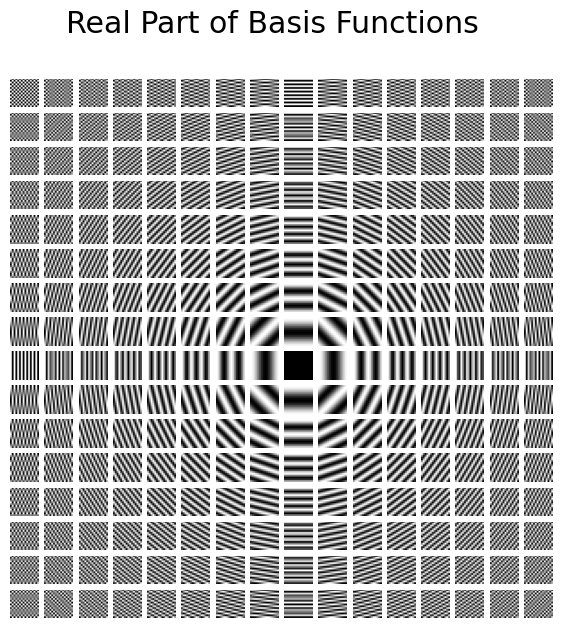

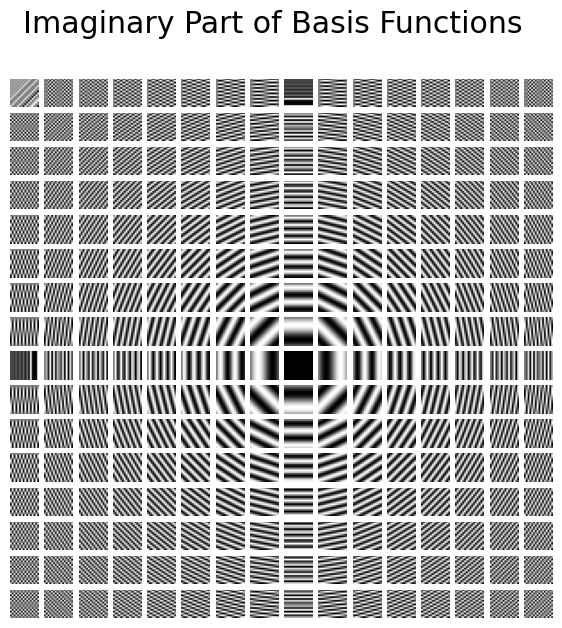

In [28]:
size = 16
bf_arr_real = np.zeros((size*size,size,size))
bf_arr_imag = np.zeros((size*size,size,size))
ind = 0
for col in range(-size//2, size//2):
  for row in range(-size//2, size//2):
    re,imag = basis_function(img_size=size, u=row, v=col)
    bf_arr_real[ind] = re
    bf_arr_imag[ind] = imag
    ind += 1

# real part
fig, axs = plt.subplots(size, size, figsize=(7, 7))
axs = axs.flatten()
for img, ax in zip(bf_arr_real, axs):
  ax.set_axis_off()
  ax.imshow(img,cmap='gray')

fig.suptitle('Real Part of Basis Functions')


# imaginary part
fig, axs = plt.subplots(size, size, figsize=(7, 7))
axs = axs.flatten()
for img, ax in zip(bf_arr_imag, axs):
  ax.set_axis_off()
  ax.imshow(img,cmap='gray')

fig.suptitle('Imaginary Part of Basis Functions')

Now, let's see the convolution of the image with a Prewitt operator.

In [29]:
K = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]) # Prewitt operator

K_padd = np.zeros((img_gray.shape[0], img_gray.shape[1]))
K_padd[:K.shape[0], :K.shape[1]] = K

# convolution
FK = np.fft.fft2(K_padd)

The Fourier transform of the Prewitt operator looks like this:

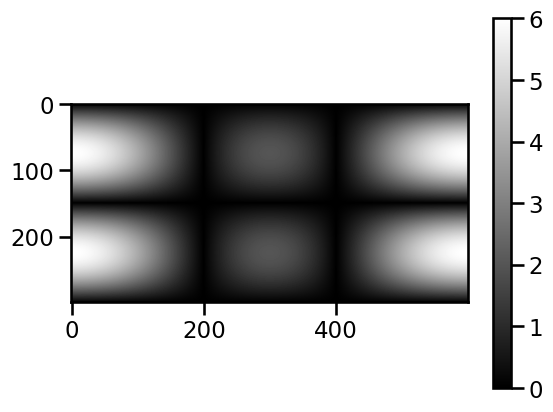

In [30]:
plt.imshow(np.abs(FK), cmap='gray')
cbar = plt.colorbar()

We can think of the frequency domain of the kernel as a **filter** that suppresses some frequencies and allows others to pass through. In the example of the Prewitt operator, the kernel `FK` has a low value around the center of the image. The product $FX \cdot FK$ then suppresses the low-frequency components of the image, and we are left with the high-frequency components that correspond to the horizontal edges. We can think of this as a high-pass filter that only allows high-frequency components to pass through.

Let's see the convolution result.

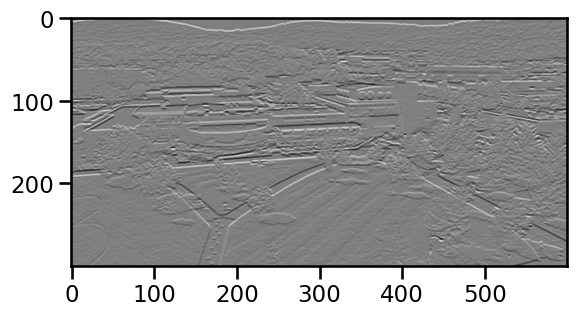

In [31]:
FX = np.fft.fft2(img_gray)
conv_img_gray = np.real(np.fft.ifft2(FX * FK))
plt.imshow(conv_img_gray, cmap='gray')

We observe that the horizontal edges are highlighted.

```{note}
A widespread application of the 2D Fourier transform is JPEG format. Here's how it works:

(1) It first breaks the image into small 8x8 squares.
(2) It converts each square into frequencies using the Discrete Cosine Transform. The sine part is discarded for compression.
(3) It keeps the important low frequencies that our eyes can see well.
(4) It throws away most of the high frequencies that our eyes don't notice much.

These steps make the file much smaller while still looking good to us.
```



## A key lesson from image processing

We have seen an equivalence between convolution in the pixel (spatial) domain and multiplication in the frequency domain.
Using the Fourier transform, an image is decomposed into a sum of basis waves.
The *kernel* can be thought of as *a filter* that suppresses some basis waves and allows others to pass through.

This idea is the key to understand graph convolutional networks we will see in the next page.

# Pen and paper exercises

- [✍️ Pen and paper exercises](pen-and-paper/exercise.pdf)
---
jupytext:
  formats: md:myst
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3
  language: python
  name: python3
---

# Popular Graph Neural Networks

In this note, we will introduce three popular GNNs: GraphSAGE, Graph Attention Networks (GAT), and Graph Isomorphism Network (GIN).

## GraphSAGE: Sample and Aggregate

GraphSAGE {footcite}`hamilton2017graphsage` introduced a different GCN that can be ***generalized to unseen nodes*** (they called it "inductive"). While previous approaches like ChebNet and GCN operate on the entire graph, GraphSAGE proposes an inductive framework that generates embeddings by sampling and aggregating features from a node's neighborhood.

![](https://theaisummer.com/static/02e23adc75fe68e5dd249a94f3c1e8cc/c483d/graphsage.png)

### Key Ideas

GraphSAGE involves two key ideas: (1) sampling and (2) aggregation.

#### Neighborhood Sampling

The key idea is the *neighborhood sampling*. Instead of using all neighbors, GraphSAGE samples a fixed-size set of neighbors for each node. This controls memory complexity, a key limitation of the previous GNNs.

Another key advantage of neighborhood sampling is that it enables GraphSAGE to handle dynamic, growing networks. Consider a citation network where new papers (nodes) are continuously added. Traditional GCNs would need to recompute filters for the entire network with each new addition. In contrast, GraphSAGE can immediately generate embeddings for new nodes by simply sampling their neighbors, without any retraining or recomputation.

#### Aggregation

Another key idea is the *aggregation*. GraphSAGE makes a distinction between self-information and neighborhood information. While previous GNNs treat them equally and aggregate them, GraphSAGE treats them differently. Specifically, GraphSAGE introduces an additional step: it concatenates the self-information and the neighborhood information as the input of the convolution.

$$
Z_v = \text{CONCAT}(X_v, X_{\mathcal{N}(v)})
$$

where $X_v$ is the feature of the node itself and $X_{\mathcal{N}(v)}$ is the aggregation of the features of its neighbors. GraphSAGE introduces different ways to aggregate information from neighbors:

   $$X_{\mathcal{N}(v)} = \text{AGGREGATE}_k(\{X_u, \forall u \in \mathcal{N}(v)\})$$

   Common aggregation functions include:
   - Mean aggregator: $\text{AGGREGATE} = \text{mean}(\{h_u, \forall u \in \mathcal{N}(v)\})$
   - Max-pooling: $\text{AGGREGATE} = \max(\{\sigma(W_{\text{pool}}h_u + b), \forall u \in \mathcal{N}(v)\})$
   - LSTM aggregator: Apply LSTM to randomly permuted neighbors

The concatenated feature $Z_v$ is normalized by the L2 norm.

$$
\hat{Z}_v = \frac{Z_v}{\|Z_v\|_2}
$$

and then fed into the convolution.

$$
X_v^k = \sigma(W^k \hat{Z}_v + b^k)
$$

## Graph Attention Networks (GAT): Differentiate Individual Neighbors

A key innovation of GraphSAGE is to treat the self and neighborhood information differently. But should all neighbors be treated equally? Graph Attention Networks (GAT) address this by letting the model learn which neighbors to pay attention to.



### Attention Mechanism

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-08_at_7.55.32_PM_vkdDcDx.png)

The core idea is beautifully simple: instead of using fixed weights like GCN, let's learn attention weights $\alpha_{ij}$ that determine how much node $i$ should attend to node $j$. These weights are computed dynamically based on node features:

$$
\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}(i)} \exp(e_{ik})}
$$

where $e_{ij}$ represents the importance of the edge between node $i$ and node $j$. Variable $e_{ij}$ is a *learnable* parameter and can be negative, and the exponential function is applied to transform it to a non-negative value, with the normalization term $\sum_{k \in \mathcal{N}(i)} \exp(e_{ik})$ to ensure the weights sum to 1.

How to compute $e_{ij}$? One simple choice is to use a neural network with a shared weight matrix $W$ and a LeakyReLU activation function. Specifically:

1. Let's focus on computing $e_{ij}$ for node $i$ and its neighbor $j$.
2. We use a shared weight matrix $W$ to transform the features of node $i$ and $j$.
   $$
   \mathbf{\tilde h}_i  = \mathbf{h}_i, \quad \mathbf{\tilde h}_j  = W\mathbf{h}_j
   $$
3. We concatenate the transformed features and apply a LeakyReLU activation function.

$$
e_{ij} = \text{LeakyReLU}(\mathbf{a}^T[\mathbf{\tilde h}_i, \mathbf{\tilde h}_j])
$$

where $\mathbf{a}$ is a trainable parameter vector that sums the two transformed features.

Once we have these attention weights, the node update is straightforward - just a weighted sum of neighbor features:

$$\mathbf{h}'_i = \sigma\left(\sum_{j \in \mathcal{N}(i) \cup \{i\}} \alpha_{ij}{\bf W}_{\text{feature}}\mathbf{h}_j\right)$$

where ${\bf W}_{\text{feature}}$ is a trainable weight matrix. To stabilize training, GAT uses multiple attention heads and concatenates their outputs:

$$\mathbf{h}'_i = \parallel_{k=1}^K \sigma\left(\sum_{j \in \mathcal{N}(i) \cup \{i\}} \alpha_{ij}^k{\bf W}^k_{\text{feature}}\mathbf{h}_j\right)$$

## Graph Isomorphism Network (GIN): Differentiate the Aggregation

Graph Isomorphism Networks (GIN) is another popular GNN that born out of a question: what is the maximum discriminative power achievable by Graph Neural Networks? The answer lies in its theoretical connection to **the Weisfeiler-Lehman (WL) test**, a powerful algorithm for graph isomorphism testing.


### Weisfeiler-Lehman Test

Are two graphs structurally identical? Graph isomorphism testing determines if two graphs are structurally identical, with applications in graph classification, clustering, and other tasks.

![](https://i.sstatic.net/j5sGu.png)

While the general problem has no known polynomial-time solution, the WL test is an efficient heuristic that works well in practice. The WL test iteratively refines node labels by hashing the multiset of neighboring labels


![](../figs/weisfeiler-lehman-test.jpg)

The WL test works as follows:

1. Assign all nodes the same initial label.
2. For each node, collect the labels of all its neighbors and *aggregate them* into a hash (e.g., new label). For example, the top node gets {0} from its neighbors, resulting in a collection {0,0}. A new label is created via a hash function $h$ that maps {0, {0, 0}} to a new label 1.
3. Repeat the process for a fixed number of iterations or until convergence.

Here is the implementation of the WL test in Python:

In [32]:
import numpy as np
from scipy import sparse

def weisfeiler_lehman_test(A, num_iterations):
    n_nodes = A.shape[0]
    labels = np.zeros(n_nodes, dtype=int)
    color_map = {}
    hash_fn = lambda x: color_map.setdefault(x, len(color_map))
    for _ in range(num_iterations):

        # Go through each node
        labels_old = labels.copy()
        for i in range(n_nodes):

            # Collect the labels of all neighbors
            neighbors = A[i].nonzero()[1]
            neighbor_labels = labels_old[neighbors]

            # Count the frequency of each label
            unique, counts = np.unique(neighbor_labels, return_counts=True)

            # Create a hash key by converting the frequency dictionary to a string
            hash_key = str({unique[j]: counts[j] for j in range(len(unique))})

            # Create a new label by hashing the frequency dictionary
            label = hash_fn(hash_key)
            labels[i] = label

        # Check convergence
        unique, counts = np.unique(labels, return_counts=True)
        unique_old, counts_old = np.unique(labels_old, return_counts=True)
        if np.array_equal(np.sort(counts), np.sort(counts_old)):
            break
    return labels


edge_list = [(0, 1), (1, 2), (2, 0), (3, 4), (4, 5), (5, 3)]

A = sparse.csr_matrix(
    ([1] * len(edge_list), ([e[0] for e in edge_list], [e[1] for e in edge_list])),
    shape=(6, 6),
)
A = A + A.T
A.sort_indices()

weisfeiler_lehman_test(A, A.shape[0])

array([0, 0, 0, 0, 0, 0])

After these iterations:
- Nodes with the same label are structurally identical, meaning that they are indistinguishable unless we label them differently.
- Two graphs are structurally identical if and only if they have the same node labels after the WL test.

The WL test is a heuristic and can fail on some graphs. For example, it cannot distinguish regular graphs with the same number of nodes and edges.

```{note}
The WL test above is called the 1-WL test. There are higher-order WL tests that can distinguish more graphs, which are the basis of advanced GNNs.
Check out [this note](https://www.moldesk.net/blog/weisfeiler-lehman-isomorphism-test/)
```

### GIN

GIN {footcite}`xu2018how` is a GNN that is based on the WL test.
The key idea is to focus on the parallel between the WL test and the GNN update rule.
- In the WL test, we iteratively collect the labels of neighbors and aggregate them through a *hash function*.
- In the GraphSAGE and GAT, the labels are the nodes' features, and the aggregation is some arithmetic operations such as mean or max.

The key difference is that the hash function in the WL test always distinguishes different sets of neighbors' labels, while the aggregation in GraphSAGE and GAT does not always do so. For example, if all nodes have the same feature (e.g., all 1), the aggregation by the mean or max will result in the same value for all nodes, whereas the hash function in the WL test can still distinguish different sets of neighbors' labels by *the count of each label*.

The resulting convolution update rule is:

$$
h_v^{(k+1)} = \text{MLP}^{(k)}\left((1 + \epsilon^{(k)}) \cdot h_v^{(k)} + \sum_{u \in \mathcal{N}(v)} h_u^{(k)}\right)
$$

where $\text{MLP}^{(k)}$ is a multi-layer perceptron (MLP) with $k$ layers, and $\epsilon^{(k)}$ is a fixed or trainable parameter.



```{footbibliography}

```
# Module 9: Graph Neural Networks

## What to learn in this module

In this module, we will learn how to use neural networks to learn representations of graphs. We will learn:
- Fourier transform on image
- Fourier transform on graph
- Spectral filters
- Graph convolutional networks
- Popular GNNs (GCN, GAT, GraphSAGE, and GIN)